# Хакатон "Геомодель" задача 2

Решение команды (а точнее *solo*) FasterThanHammer  
Мария Смирнова / [@SmirnovaMariaD](t.me/SmirnovaMariaD)      

**В этой тетрадке обучаем выбранную архитектуру и делаем заготовку для инференса**  
Тетрадка с подбором архитектуры ===ЗДЕСЬ===  
Тетрадка с анализом данных ===ЗДЕСЬ===

**Summary**  
Используется модель `CoordsModUnet` - модифицированная Unet, учитывающая расстояния между точкой удара и сенсором, а также рассположение сенсора - класс данных `FTHCoordsDataset` 

# Импорты и подготовка данных

## Импорты и загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Hach_geomodel')

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import numpy as np
import os
import h5py
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
import geopandas as gpd
import pandas as pd
from matplotlib.ticker import MaxNLocator
from tqdm.auto import tqdm
import datetime
import torch.nn.functional as F
import torch.fft

import FTH_coords_dataset
import FTH.CoordsModUnet
import FTH.FFTCoordsModUnet

In [ ]:
base_path = '/content/drive/MyDrive/Colab Notebooks/Hach_geomodel/'
path = base_path + r'data/'
file_path_14 = path+r'14m/batch_14m.hdf5'
file_path_9 = path+r'9m/batch_9m.hdf5'
file_sensors_data_path = path+'sensors_data.txt'
file_points_data_path = path+'points_data.txt'

# path to save model's weights
saving_path = base_path +  r'models_weights'

# для таблицы сравнения моделей
df_path = base_path + r''

# модели для разных каналов
channel_models_dict = {
    'Z' : 'CoordsModUnet_Z_epoch_320_final.pth',
    'Y' : 'CoordsModUnet_Y_epoch_320_final.pth',
    'X' : 'CoordsModUnet_X_epoch_320_final.pth'
}

## Параметры

**Задаём параметры** для обучения модели

In [3]:
train_fraction = 0.8  # доля сэмплов для обучения
selected_sensors_num = 2016 #  для быстрого запуска берем 10 сенсоров (в задаче необходимо использовать все сенсоры)
batch_size = 32
epochs = 1
learning_rate = 0.01

## Предобработка данных и функции визуализации

In [4]:
with open(file_sensors_data_path) as f:
    sensors_data = [line.split() for line in f]
sensors_names = [str(sub[0]) for sub in sensors_data]

points_data = []
with open(file_points_data_path) as f:
    points_data = ([line.split() for line in f])


df = gpd.GeoDataFrame(sensors_data, columns=(['sensor_name', 'x', 'y', 'z']))
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y'], df['z']))
df_impact = gpd.GeoDataFrame(points_data, columns=(['sensor_name', 'x', 'y', 'z']))
df_impact = gpd.GeoDataFrame(df_impact, geometry=gpd.points_from_xy(df_impact['x'], df_impact['y'], df_impact['z']))

for _, impact_point in df_impact.iterrows():
    impact_name = impact_point['sensor_name']
    distances = df.geometry.distance(impact_point.geometry)
    df[f'dist_to_{impact_name}'] = distances

In [5]:
def plot_teaching(train_loss: list, val_loss: list, epochs: int):
    # Создаем фигуру с настроенным размером
    plt.figure(figsize=(10, 6), dpi=100)

    plt.style.use('seaborn-v0_8')
    
    # Рисуем кривые обучения
    plt.plot(train_loss, 
             label=f'Train Loss (min: {min(train_loss):.4f})',
             linewidth=2.5,
             color='#1f77b4',
             marker='o',
             markersize=6,
             markeredgecolor='black',
             markerfacecolor='blue')
    
    plt.plot(val_loss, 
             label=f'Validation Loss (min: {min(val_loss):.4f})',
             linewidth=2.5,
             color='#ff7f0e',
             marker='s',
             markersize=6,
             markeredgecolor='black',
             markerfacecolor='orange')
    
    # Настройка осей и сетки
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Только целые значения на оси X
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('Epoch', fontsize=12, labelpad=10)
    plt.ylabel('Loss', fontsize=12, labelpad=10)
    plt.title('Training and Validation Loss', fontsize=14, pad=20)
    
    # Легенда
    plt.legend(fontsize=10, framealpha=1, shadow=True)
    
    # Улучшенные границы
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_linewidth(0.5)
    plt.gca().spines['bottom'].set_linewidth(0.5)
    
    # Фон
    plt.gca().set_facecolor('#f5f5f5')
    plt.gcf().set_facecolor('white')
    
    # Логарифмическая шкала
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

# подгрузка таблицы моделей
model_comparison_path = os.path.join(df_path, "model_comparison.csv")
   
if os.path.exists(model_comparison_path):
    print(f"Loading existing model comparison from {model_comparison_path}")
    try:
        model_comparison = pd.read_csv(model_comparison_path)
    except Exception as e:
        print(f"Error loading file, creating new one. Error: {e}")
        model_comparison = pd.DataFrame(columns=['model', 'val_loss', 'train_loss', 'best_val_loss', 'best_train_loss', 'epochs', 'sensors_num', 'datetime'])        
else:
    print(f"No existing model comparison found at {model_comparison_path}, creating new one")
    model_comparison = pd.DataFrame(columns=['model', 'val_loss', 'train_loss', 'best_val_loss', 'best_train_loss', 'epochs', 'sensors_num', 'datetime'])


def highlight_rows(row, model_name):
    color = 'background-color: yellow' if row['model'] == model_name else ''
    return [color] * len(row)

def plot_predictions_eval(inputs, preds, targets, num_samples=3):
        fig, axes = plt.subplots(num_samples, 1, figsize=(12, 3*num_samples))
        if num_samples == 1:
            axes = [axes]
            
        for i in range(min(num_samples, inputs.shape[0])):
            ax = axes[i]
            time = np.arange(inputs.shape[2])
            
            ax.plot(time, inputs[i][0], 'b-', alpha=0.5, label='Input')
            ax.plot(time, targets[i][0], 'g-', label='True Output')
            ax.plot(time, preds[i][0], 'r--', label='Prediction')
            
            ax.legend()
            ax.grid(True)
        plt.tight_layout()
        plt.show()

def plot_predictions(model, dataloader, device, num_samples=3):
        model.eval()
        fig, axes = plt.subplots(num_samples, 1, figsize=(12, 3*num_samples))
        if num_samples == 1:
            axes = [axes]
            
        with torch.no_grad():
            try:
                for inputs, targets, distances in dataloader:
                    inputs = inputs.float().to(device)
                    distances = distances.float().to(device)
                    preds = model(inputs, distances).cpu().numpy()
                    
                    inputs = inputs.cpu().numpy()
                    targets = targets.cpu().numpy()
                    
                    for i in range(min(num_samples, inputs.shape[0])):
                        ax = axes[i]
                        time = np.arange(inputs.shape[2])
                        
                        ax.plot(time, inputs[i][0], 'b-', alpha=0.5, label='Input')
                        ax.plot(time, targets[i][0], 'g-', label='True Output')
                        ax.plot(time, preds[i][0], 'r--', label='Prediction')
                        
                        ax.legend()
                        ax.grid(True)
                    
                    if i >= num_samples-1:
                        break
            except:
                 for inputs, targets in dataloader:
                    inputs = inputs.float().to(device)
                    preds = model(inputs).cpu().numpy()
                    
                    inputs = inputs.cpu().numpy()
                    targets = targets.cpu().numpy()
                    
                    for i in range(min(num_samples, inputs.shape[0])):
                        ax = axes[i]
                        time = np.arange(inputs.shape[2])
                        
                        ax.plot(time, inputs[i][0], 'b-', alpha=0.5, label='Input')
                        ax.plot(time, targets[i][0], 'g-', label='True Output')
                        ax.plot(time, preds[i][0], 'r--', label='Prediction')
                        
                        ax.legend()
                        ax.grid(True)
                    
                    if i >= num_samples-1:
                        break
                    
        plt.tight_layout()
        plt.show()

Loading existing model comparison from model_comparison.csv


# Предсказания на выбранной архитектуре

In [ ]:
def load_model_weights(model, saved_weight_path):
    try:
        state_dict = torch.load(saved_weight_path)
        model.load_state_dict(state_dict)
        print(f"Успешно загружены веса из {saved_weight_path}")

    except Exception as e:
      try:
        state_dict = torch.load(saved_weight_path, map_location=torch.device('cpu'))
        print(f"Успешно загружены веса из {saved_weight_path}")
      except:
        print(f"Ошибка загрузки весов из {saved_weight_path}: {e}")

    return model

def evaluate_model(data, model_class, channels):
    predictions = {}
    for ch in channels:
        model = model_class()
        model_path = os.path.join(saving_path, channel_models_dict[ch])
        model = load_model_weights(model, model_path)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f'Модель работает на {device}')
        model.to(device)

        model.eval()
        all_preds = []
        all_targets = []
        all_inputs = []
        dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
        
        with torch.no_grad():
            for batch in dataloader:
                inputs, targets, distances = batch
                inputs = inputs.float().to(device)
                distances = distances.float().to(device)
                preds = model(inputs, distances)
                all_preds.append(preds.cpu())
                all_targets.append(targets.cpu())
                all_inputs.append(inputs.cpu())
        
        # Конкатенируем все батчи
        preds = torch.cat(all_preds, dim=0).numpy()
        targets = torch.cat(all_targets, dim=0).numpy()
        inputs = torch.cat(all_inputs, dim=0).numpy()
        predictions[ch] = preds

        
        mae = mean_absolute_error(targets.flatten(), preds.flatten())
        print(f'Для канала {ch} метрика МАЕ: {mae}')
        
        num_samples = 3
        plot_predictions_eval(inputs, preds, targets, num_samples=num_samples)

    return predictions

**Задаём параметры** канала и точек удара (как для предсказаний, так и для обучения)


**ВНИМАНИЕ** при запуске в коллабе, если не доступен GPU, могут возникать проблемы с подгрузкой весов. В функции загрузки это учтено, но могут возникать сложности с расчётами

In [7]:
channels = ['Z','Y']  # например, для обучения берем канал Z, все каналы доступны через ['Z','X','Y']
num_sources_points = [1] # номера точек ударов

Успешно загружены веса из models_weights\CoordsModUnet_Z_epoch_320_final.pth
Модель работает на cuda
Для канала Z метрика МАЕ: 0.02448599971830845


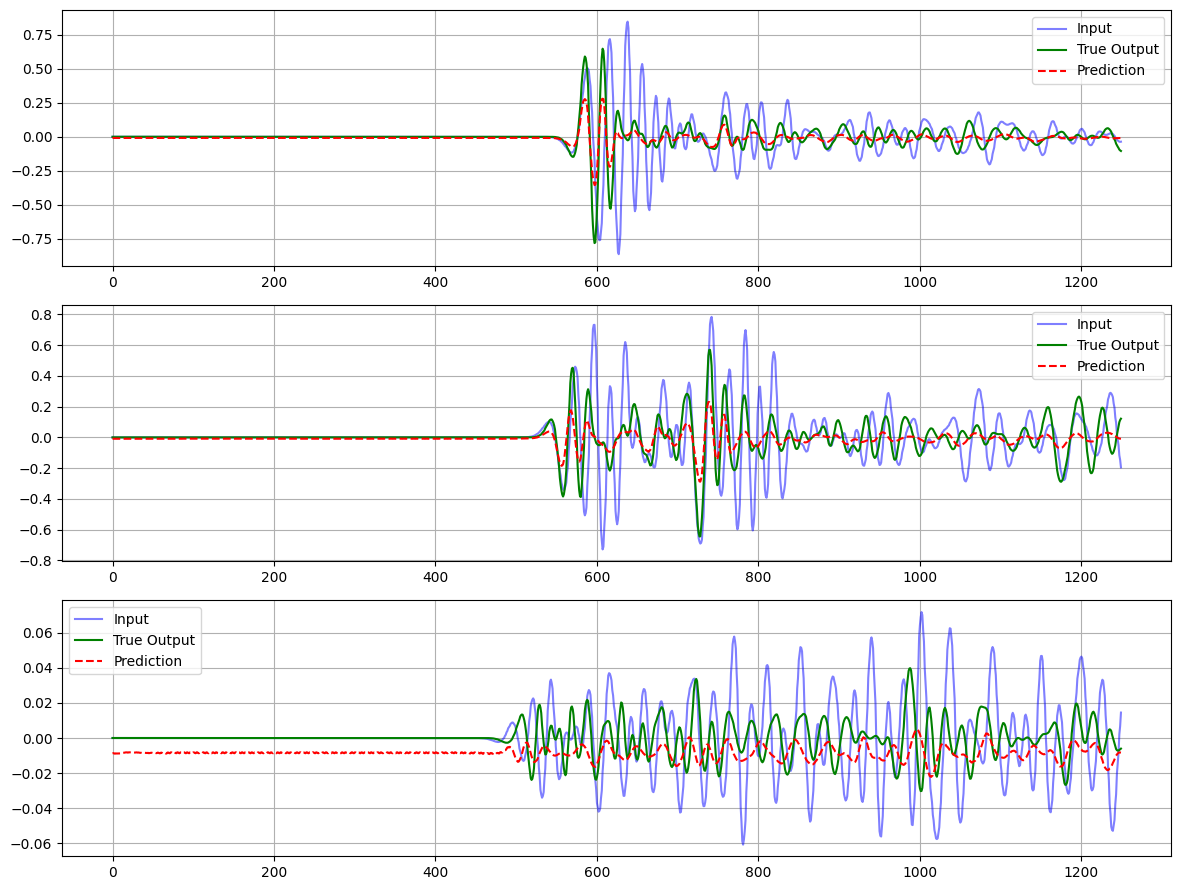

Успешно загружены веса из models_weights\CoordsModUnet_Y_epoch_320_final.pth
Модель работает на cuda
Для канала Y метрика МАЕ: 0.02480482868850231


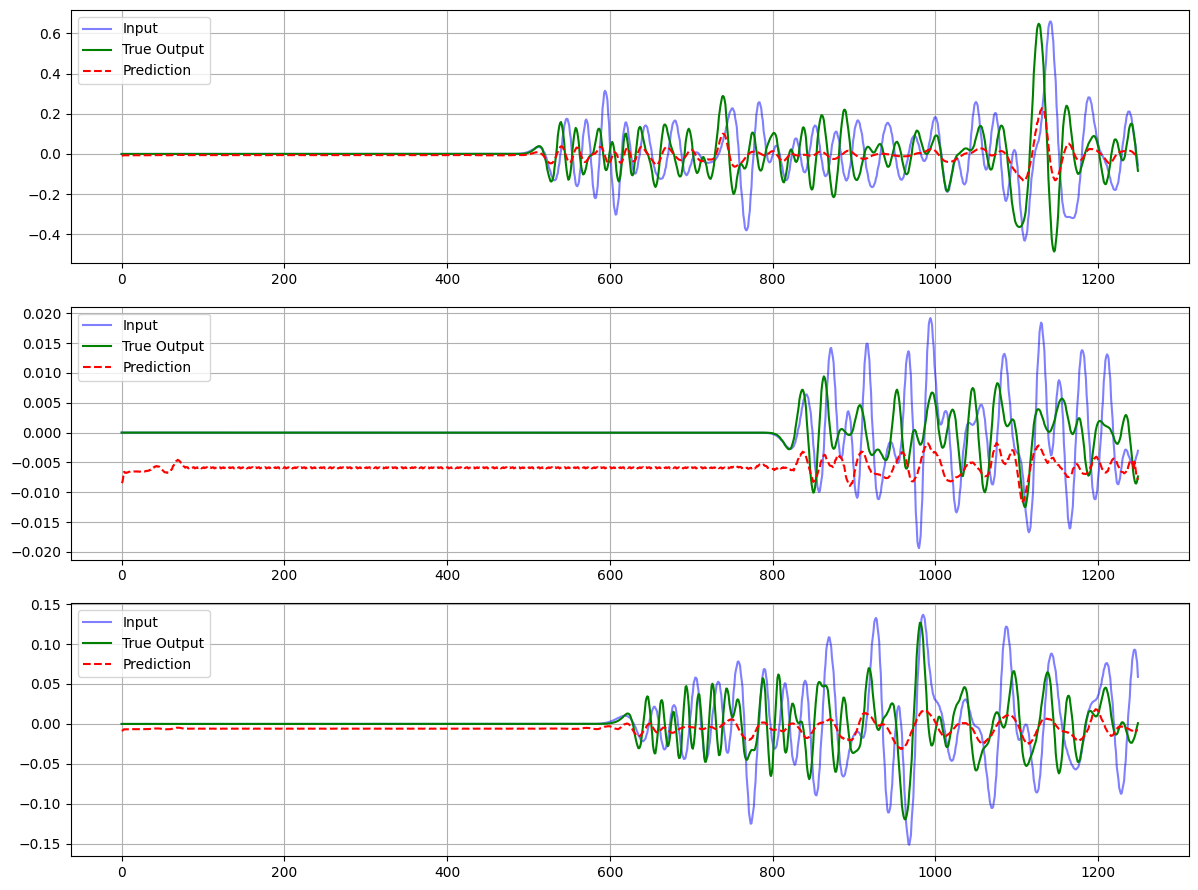

In [9]:
for ch in channels:
    data = FTH_coords_dataset.FTHCoordsDataset(input_batch=file_path_14,
                            output_batch=file_path_9,
                            selected_sensors_names=sensors_names,
                            number_sources_points = num_sources_points,
                            sensors_names=sensors_names,
                            distances_df = df,
                            channels=ch)

    predictions = evaluate_model(data=data,  model_class=FTH.CoordsModUnet.CoordsModUnet, channels=ch)

# Обучение выбранной архитектуры

**Функции обучения и загрузки весов модели**

In [13]:
def load_model_weights(model, saved_weight_path):
    pattern = re.compile(rf".*_epoch_(\d+)\.pth$")
    filename = saved_weight_path
    match = pattern.search(filename)
    if match:
        current_epoch = int(match.group(1))
        print(f'Загружены веса обучавшиеся {current_epoch} эпох/эпохах')
    try:
        state_dict = torch.load(saved_weight_path)
        model.load_state_dict(state_dict)
        print(f"Успешно загружены веса из {saved_weight_path}")

    except Exception as e:
        print(f"Ошибка загрузки весов из {saved_weight_path}: {e}")
    
    return model, current_epoch


def prapere_and_train_model(model_name, data, model_class, model_comparison, saved_weight_path=None, fft=False):
    model = model_class()
    starting_epochs = 0
    if saved_weight_path is not None:
        model, starting_epochs = load_model_weights(model, saved_weight_path)
    # else:
    #     return model_comparison, model

    train_size = int(train_fraction * len(data))
    val_size = len(data) - train_size
    train_data, val_data = random_split(data, [train_size, val_size])

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'Модель обучается на: {device}')
    model.to(device)
    
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss = []
    val_loss = []
    for epoch in tqdm(range(epochs), desc='Training'):

        batch_train_loss = []
        batch_val_loss = []

        model.train()
        for inputs, output, distances in train_dataloader:
            inputs = inputs.float().to(device)
            output = output.float().to(device)
            distances = distances.float().to(device)

            if fft:
                inputs_fft = torch.fft.rfft(inputs, dim=-1)
                real_part = inputs_fft.real
                imag_part = inputs_fft.imag
                inputs = torch.stack([real_part, imag_part], dim=1)

            predicted_output = model(inputs, distances)
            
            if fft:
                reconstructed_outputs = torch.complex(predicted_output[:, 0], predicted_output[:, 1]).to(device)
                predicted_output = torch.fft.irfft(reconstructed_outputs, dim=-1)
            
            loss = criterion(predicted_output, output)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_train_loss.append(loss.item())

            if (epoch + 1) % 40 == 0:
                save_path = os.path.join(saving_path, f'{model_name}_epoch_{starting_epochs+epoch+1}.pth')
                torch.save(model.state_dict(), save_path)
                #print(f"Модель сохранена: {save_path}")

        train_loss.append(np.mean(batch_train_loss))

        model.eval()
        for inputs, output, distances in val_dataloader:
            inputs = inputs.float().to(device)
            output = output.float().to(device)
            distances = distances.float().to(device)

            if fft:
                inputs_fft = torch.fft.rfft(inputs, dim=-1)
                real_part = inputs_fft.real
                imag_part = inputs_fft.imag
                inputs = torch.stack([real_part, imag_part], dim=1)

            predicted_output = model(inputs, distances)

            if fft:
                # Check if predicted_output has shape [batch, 2, n_fft]
                if predicted_output.shape[1] == 2:
                    real_part = predicted_output[:, 0]  # Take real channel
                    imag_part = predicted_output[:, 1]  # Take imaginary channel
                else:
                    raise ValueError("Expected 2 channels for FFT output")
                
                # Reconstruct time-domain signal
                predicted_output = torch.fft.irfft(
                    torch.complex(real_part, imag_part),
                    dim=-1
                )

                # Also ensure ground truth is in time domain
                if torch.is_complex(output):
                    output = torch.fft.irfft(output, dim=-1)

            # Compute loss (both tensors now in same domain)
            loss = criterion(predicted_output, output)
            batch_val_loss.append(loss.item())

    val_loss.append(np.mean(batch_val_loss))

        #print(f'epoch {epoch}, train_loss {np.mean(batch_train_loss)}, val_loss {np.mean(batch_val_loss)}')
    
    plot_predictions(model, val_dataloader, device, num_samples=2)
    plot_teaching(train_loss, val_loss, len(train_loss))
    
    time = datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    new_row = [model_name, np.mean(batch_val_loss), np.mean(batch_train_loss), 
               min(val_loss), min(train_loss), epochs+starting_epochs, selected_sensors_num, time]
    model_comparison = pd.concat([model_comparison, pd.DataFrame([new_row], columns=model_comparison.columns)], ignore_index=True)
    filtered = model_comparison.query("sensors_num >= 1000")
    filtered = filtered.sort_values(by='val_loss')
    styled = filtered.style.apply(highlight_rows, args=(model_name,), axis=1)
    display(styled)
    model_comparison.to_csv(model_comparison_path, index=False)
    
    return model_comparison, model

Настройка параметров обучения  
Все веса можно найти в репозитории `models_weights` -  итоговые модели обучены на 320 эпохах

In [ ]:
channels = ['Z','Y']  # например, для обучения берем канал Z, все каналы доступны через ['Z','X','Y']
num_sources_points = [1] # номера точек ударов
train_fraction = 0.8  # доля сэмплов для обучения
selected_sensors_num = 2016 #  для быстрого запуска берем 10 сенсоров (в задаче необходимо использовать все сенсоры)
batch_size = 32
epochs = 1 #для пример возьмём просто одну эпоху


Модель обучается на: cuda


Training:   0%|          | 0/1 [00:00<?, ?it/s]

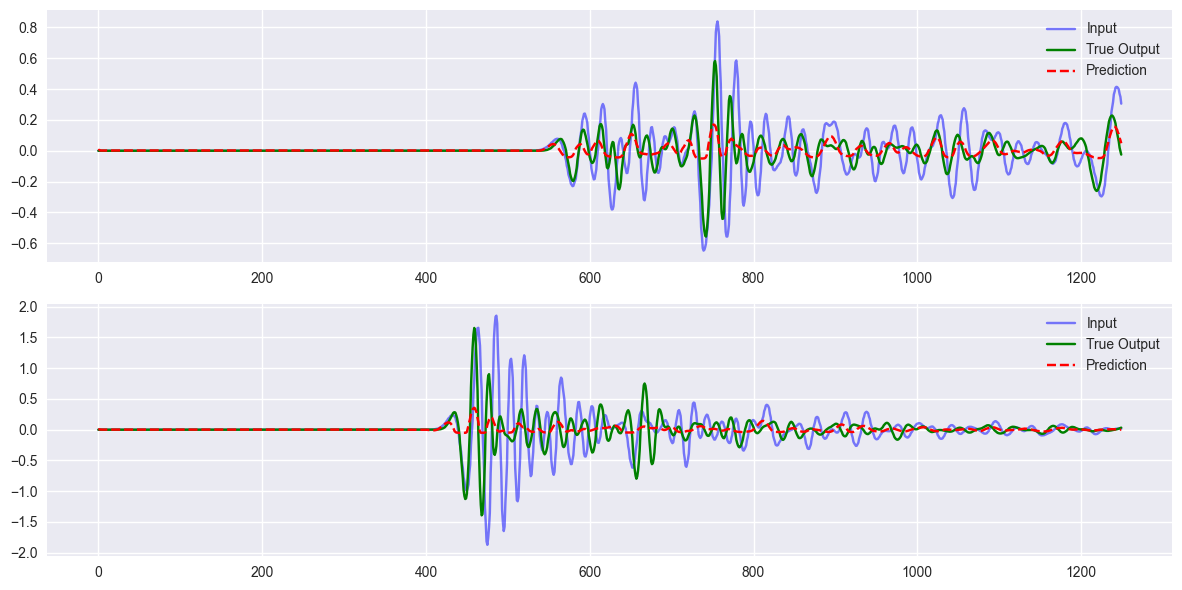

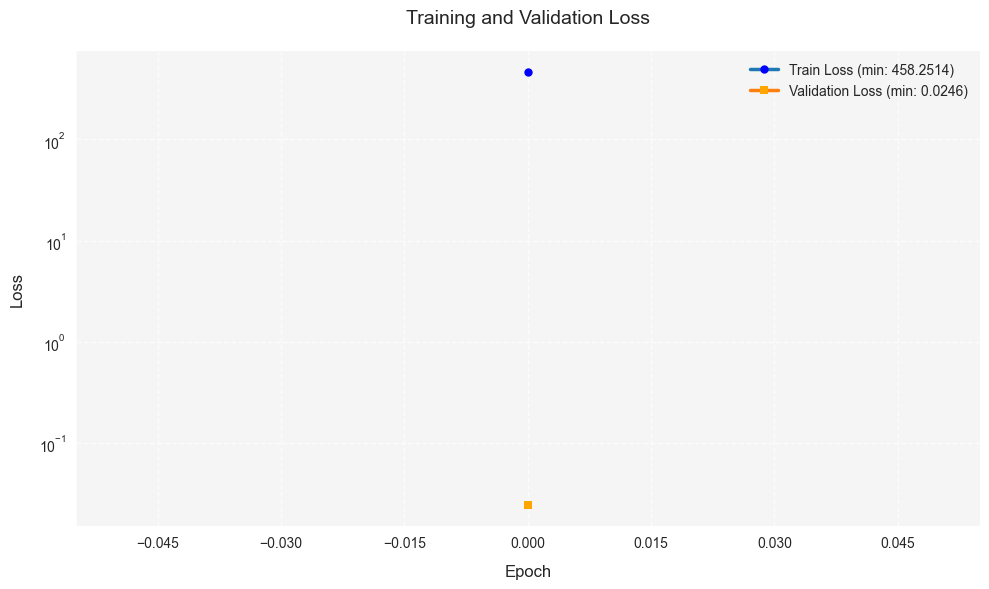

,model,val_loss,train_loss,best_val_loss,best_train_loss,epochs,sensors_num,datetime
7,ModUnet,0.019860,0.022311,0.018911,0.022136,30,2016,"05/14/2025, 03:29:46"
8,CoordsModUnet,0.021398,0.023143,0.019190,0.022765,30,2016,"05/14/2025, 03:53:46"
6,GNN_Z,0.024495,0.039251,0.019296,0.030151,30,2016,"05/14/2025, 03:20:14"
10,CoordsModUnet_Z,0.024569,458.251369,0.024569,458.251369,1,2016,"05/14/2025, 18:48:21"
2,baseline_unet,0.024654,0.024469,0.024243,0.024306,30,2016,"05/14/2025, 02:47:40"
3,baseline_unet+dist to impact,0.024821,0.024536,0.023988,0.024468,30,2016,"05/14/2025, 02:56:44"
4,SimpleModel+dist to impact,0.027044,0.027040,0.026842,0.026992,30,2016,"05/14/2025, 03:06:13"
5,CNN_LSTM,0.027984,0.027051,0.027364,0.026845,30,2016,"05/14/2025, 03:16:53"
1,dummy_model_Fourier,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:47"
0,dummy_model,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:43"


Модель обучается на: cuda


Training:   0%|          | 0/1 [00:00<?, ?it/s]

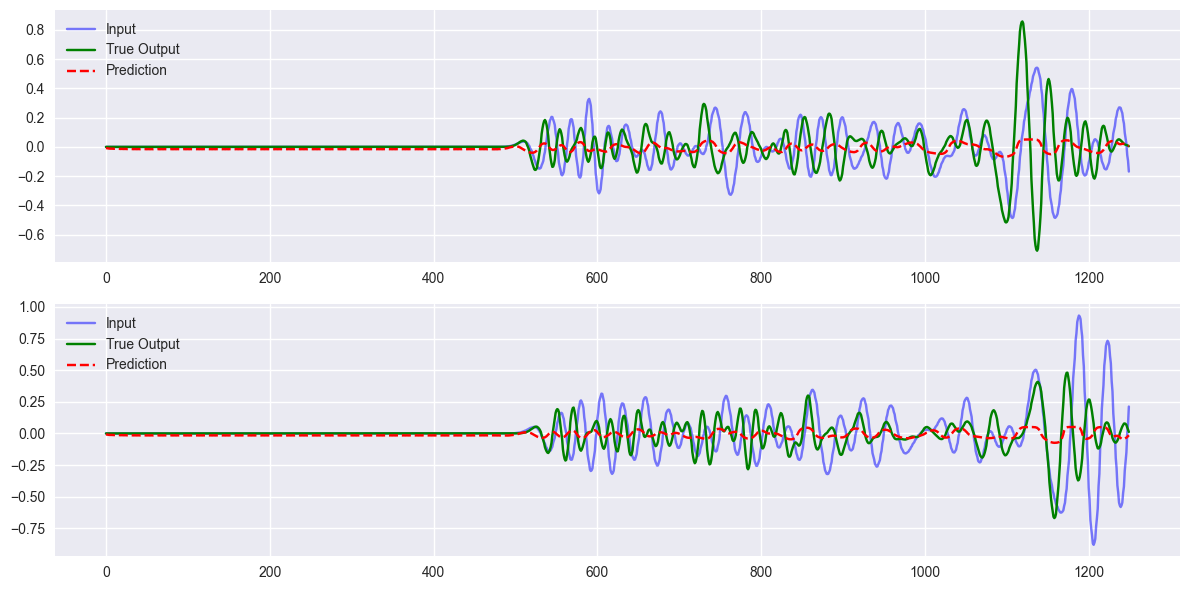

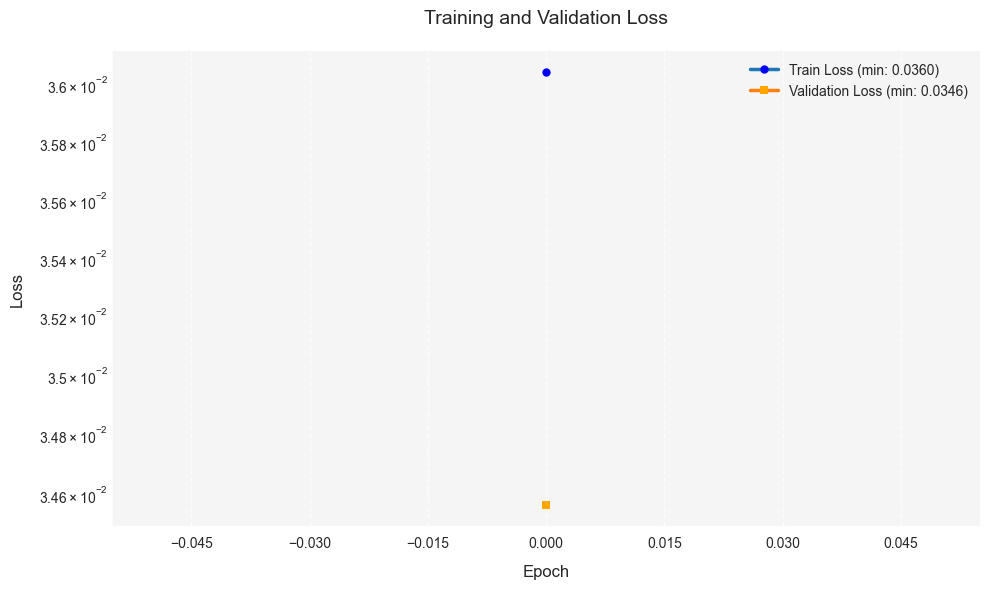

,model,val_loss,train_loss,best_val_loss,best_train_loss,epochs,sensors_num,datetime
7,ModUnet,0.019860,0.022311,0.018911,0.022136,30,2016,"05/14/2025, 03:29:46"
8,CoordsModUnet,0.021398,0.023143,0.019190,0.022765,30,2016,"05/14/2025, 03:53:46"
6,GNN_Z,0.024495,0.039251,0.019296,0.030151,30,2016,"05/14/2025, 03:20:14"
10,CoordsModUnet_Z,0.024569,458.251369,0.024569,458.251369,1,2016,"05/14/2025, 18:48:21"
2,baseline_unet,0.024654,0.024469,0.024243,0.024306,30,2016,"05/14/2025, 02:47:40"
3,baseline_unet+dist to impact,0.024821,0.024536,0.023988,0.024468,30,2016,"05/14/2025, 02:56:44"
4,SimpleModel+dist to impact,0.027044,0.027040,0.026842,0.026992,30,2016,"05/14/2025, 03:06:13"
5,CNN_LSTM,0.027984,0.027051,0.027364,0.026845,30,2016,"05/14/2025, 03:16:53"
11,CoordsModUnet_Y,0.034563,0.036041,0.034563,0.036041,1,2016,"05/14/2025, 18:50:20"
0,dummy_model,0.045832,0.045832,0.045832,0.045832,30,2016,"05/14/2025, 02:43:43"


In [16]:
for ch in channels:
    model_name = 'CoordsModUnet'+"_"+ch
    data = FTH_coords_dataset.FTHCoordsDataset(input_batch=file_path_14,
                            output_batch=file_path_9,
                            selected_sensors_names=sensors_names[:selected_sensors_num],
                            number_sources_points = num_sources_points,
                            sensors_names=sensors_names,
                            distances_df = df,
                            channels=ch)


    #saved_path = r'models_weights\CoordsModUnet_epoch_280.pth'
    saved_path = None
    model_comparison, model = prapere_and_train_model(model_name, data, FTH.CoordsModUnet.CoordsModUnet, model_comparison, saved_path)

    # сохраняем версию с постфиксом _final
    save_path = os.path.join(saving_path, model_name+"_epoch_" + str(epochs)+"_final.pth")
    torch.save(model.state_dict(), save_path)
